# **Portfolio optimization**

## Imports

In [64]:

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import cvxpy as cp
import sys
sys.path.append('../src')
from utils import singularities

## Importing data

In [68]:
dataset = pd.read_csv('../data/raw/markowitz_dataset.csv', encoding='latin1', usecols=['N°DPE', 'taux_credit', 'Emission_GES_kgCO2_m2_an'])

## Solving the optimization problem

We will use the convex optimization python module `cvxpy` to solve the following optimization problem:

$$
\max_w \sum_i w_i r_i
$$

where $w_i$ are the weights of each asset in the portfolio and $r_i$ are the corresponding returns.

With the following constraints:
- $\sum_i w_i e_i$ minimal (minimize carbon emissions), with $e_i$ the emissions of the asset $i$.
- $\sum_i w_i = 1$
- $\forall i:\ w_i \geq 0$ (no short-selling)
- Eventually, we could fix a threshold $t$ and guarantee that $\forall i:\ w_i \leq t$

### Example

In the following we apply this on an example of an emission threshold of $e_{max} = 6\ kgCO_2e/m^2/year$ (enforce $\sum_i w_i e_i \leq e_{max}$)

In [69]:
# Inputs
r = np.array(dataset.taux_credit)
e = np.array(dataset.Emission_GES_kgCO2_m2_an)
n = len(r)

# Problem
w = cp.Variable(n, nonneg=True)
e_max = 6
objective = cp.Minimize(- w@r)
contraints = [
    cp.sum(w) == 1, 
    w@e <= e_max
]


# Résolution
prob = cp.Problem(objective, contraints)
prob.solve()

-0.07000000002016656

Optimal return: 0.07
Minimal emissions: 6.00


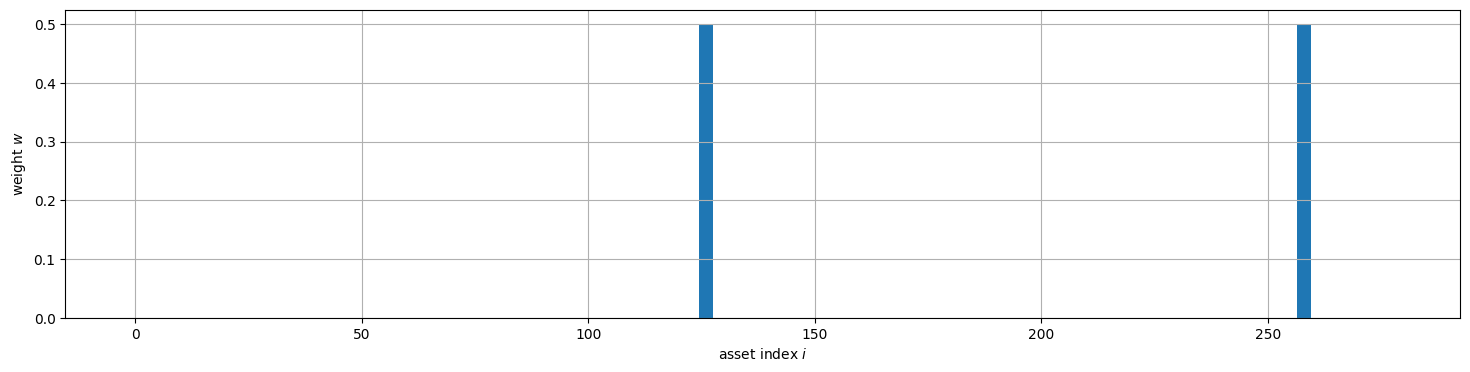

In [71]:
w_opt = w.value

# Displaying results
print(f"Optimal return: {w_opt@r:.2f}")
print(f"Minimal emissions: {w_opt@e:.2f}")

# Visualization
fig = plt.figure(figsize=(18, 4))
plt.ylabel('weight $w$')
plt.xlabel('asset index $i$')
plt.bar(width=3, x=range(n), height=w_opt)
plt.grid(True)
plt.show()

The algorithm suggests splitting the portfolio between two assets. Let's go back to the raw data and find out the adresses of these assets.

In [72]:
chosen_ids = [i for i in range(len(w_opt)) if w_opt[i]>1e-6]  # Indexes of the chosen assets
chosen_numdpe = dataset.iloc[chosen_ids, 0]
chosen_numdpe

126    2475T2211070T
258    2314T3079358B
Name: N°DPE, dtype: object

In [73]:
data_raw = pd.read_csv('../data/raw/dpe-v2-tertiaire-2.csv')  # Original data to extract the address

In [74]:
data_raw[data_raw['N°DPE'].isin(chosen_numdpe)][['Adresse_brute', 'Code_postal_(BAN)', 'Nom__commune_(BAN)']]

,Adresse_brute,Code_postal_(BAN),Nom__commune_(BAN)
102713,29 RUE DU COMMERCE,75015.0,Paris
183305,11 RUE GUILLLAUME LECONQUERANT,14790.0,Fontaine-Étoupefour


### Efficient frontier

Now instead of fixing a particular threshold for carbon emissions, we are going to vary the threshold in order to plot the equivalent of Markowitz' **Efficient Frontier**.

In [75]:
r_opt = []
e_opt = []
w_opt = []

for t in np.arange(0.5, 10, 0.1):
    w = cp.Variable(n, nonneg=True)
    objective = cp.Minimize(- w@r)
    contraints = [
        cp.sum(w) == 1, 
        w@e <= t
    ]


    # Résolution
    prob = cp.Problem(objective, contraints)
    prob.solve()
    
    w = w.value
    
    w_opt.append(w)
    r_opt.append(w@r)
    e_opt.append(w@e)

[2.00000001 0.05      ]
[6.00000001 0.07      ]


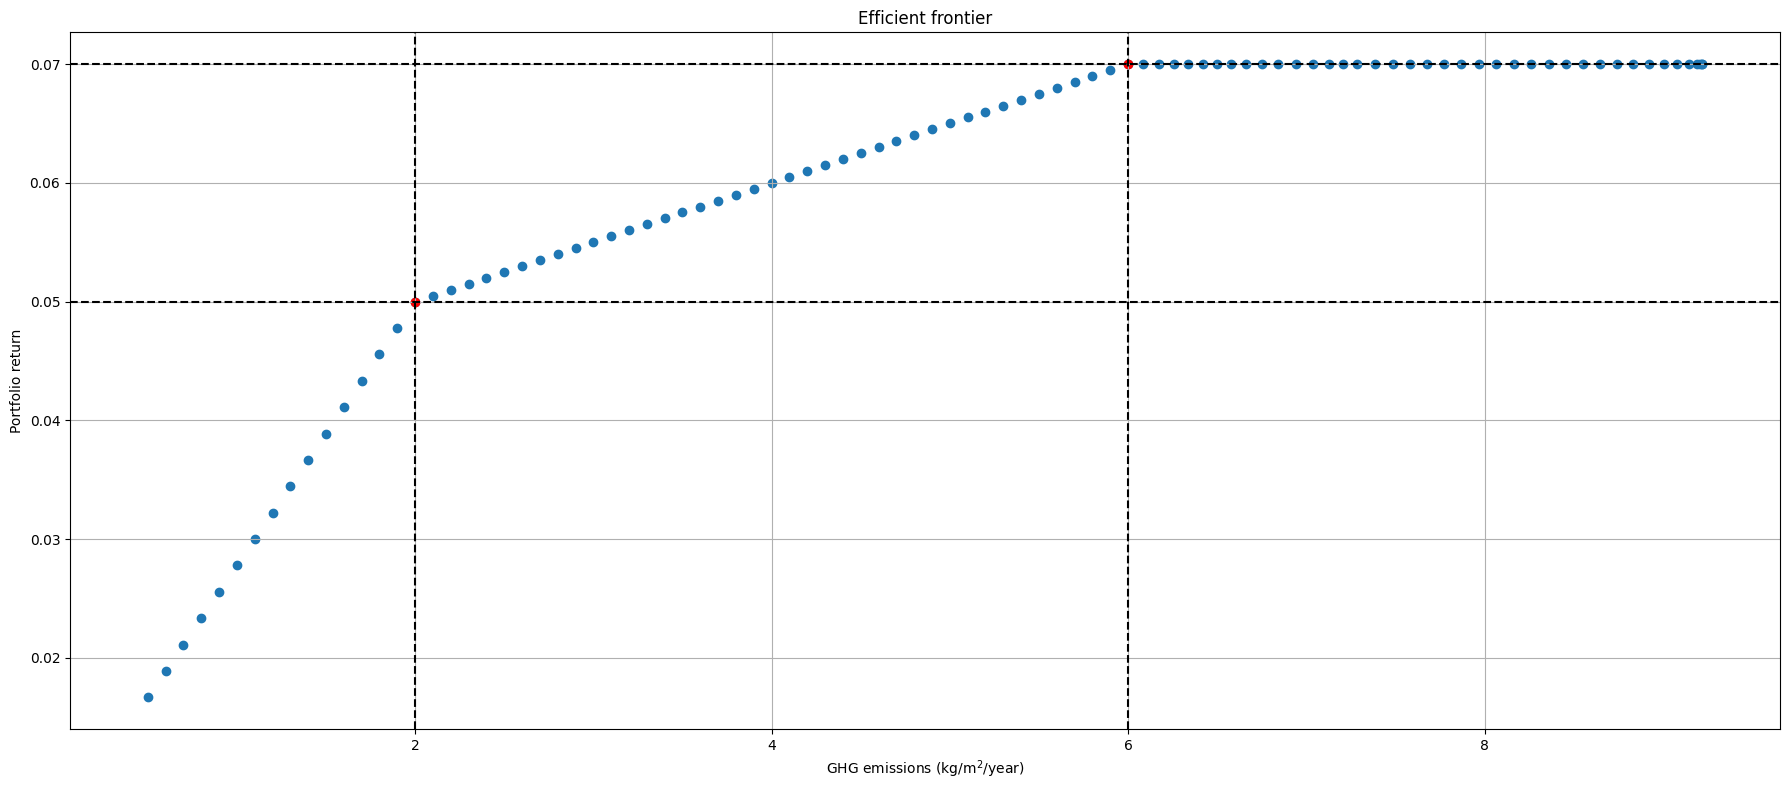

In [78]:
fig = plt.figure(figsize=(18, 8))

singu = np.array(singularities(e_opt, r_opt, tol=1e-6))  # To indicate singular points where the slope changes
plt.scatter(x=e_opt, y=r_opt)
plt.scatter(x=singu[:, 0], y=singu[:, 1], color='red')

for s in singu:
    print(s)
    plt.axvline(x=s[0], linestyle='--', color='black')
    plt.axhline(y=s[1], linestyle='--', color='black')

plt.grid(True)
plt.ylabel("Portfolio return")
plt.xlabel("GHG emissions (kg/m$^2$/year)")
plt.title("Efficient frontier")
plt.tight_layout()
plt.show()

Finally, depending on the satisfaction/utility curve of the bank, a point of the efficient frontier is chosen and the address can be extracted like we did for the example above.